In [38]:
# inference process wirte here 
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from transformers import CLIPProcessor, CLIPModel
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
from utilities import *
import matplotlib.pyplot as plt
from u_net import Unet

In [39]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
timesteps = 500
beta1 = 1e-4
beta2 = 0.02
n_feat = 128
n_cfeat = 512
height = 64
save_dir = '/Users/chenyufeng/desktop/smartBrush/checkpoint'
batch_size = 100
n_epoch = 32
lrate=1e-3
text='girl'

b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1


processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")

inputs = processor(text=text, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    text_embeddings = model.get_text_features(**inputs).squeeze(0).to(device)  

In [40]:
model = Unet(in_channels=3, n_feat=n_feat, n_cfeat=512, height=height).to(device)

/var/folders/2n/_rbq8jq91v966vqcpqx6wx0w0000gn/T/ipykernel_21170/2436629627.py:46: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  mask_s_image = mask_s_image.resize( (64,64),Image.ANTIALIAS)
/var/folders/2n/_rbq8jq91v966vqcpqx6wx0w0000gn/T/ipykernel_21170/2436629627.py:47: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  original_image = original_image.resize( (64,64), Image.ANTIALIAS)


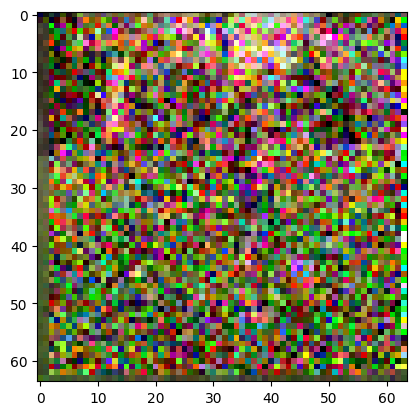

In [52]:
from PIL import Image, ImageOps  
def denoise_add_noise(x,  t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise



@torch.no_grad()
def sample_ddpm(n_sample, mask,save_rate=20):
    samples = torch.randn(n_sample, 3, height, height).to(device)
    intermediate = [] 
    for i in range(timesteps, 0, -1):
        samples = samples*mask+x0*(1-mask)
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)
        z = torch.randn_like(samples) if i > 1 else 0


        eps,mask_pred = model(samples, t,text_embeddings,mask)    # predict noise e_(x_t,t)
        mask = (torch.sigmoid(mask_pred)>0.5).float()
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate ==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())
        mask_numpy = mask.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
        samples_numpy = samples.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
        samples_numpy = np.clip(samples_numpy, 0,1)
        mask_numpy = np.clip(mask_numpy,0,1)

        plt.imshow(mask_numpy)
        plt.imshow(samples_numpy)
@torch.no_grad()
def sample_ddpm_context(n_sample, mask,x0, save_rate=20):
    #原始数据
    samples = torch.randn(n_sample, 3, height, height).to(device)  
    intermediate = [] 
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)
        #每个时间步的噪声
        z = torch.randn_like(samples) if i > 1 else 0

        noise_pred,mask_pred = model(x=samples, t=t, c=text_embeddings, mask=mask) 
        mask = (torch.sigmoid(mask_pred)>0.5).float()

        samples = noise_pred * mask + x0 * (1-mask)
        
        #每个时间步对原始数据进行降噪
        samples = denoise_add_noise(samples, i, noise_pred, z)

        
        if i % save_rate==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate


    intermediate = np.stack(intermediate)
    return samples,mask, intermediate


x0_path = '/Users/chenyufeng/desktop/girl_data/girl.png'
mask_s_path = '/Users/chenyufeng/desktop/girl_data/3.png'

mask_s_image = Image.open(mask_s_path)
original_image = Image.open(x0_path)

mask_s_image = mask_s_image.resize( (64,64),Image.ANTIALIAS)
original_image = original_image.resize( (64,64), Image.ANTIALIAS)

mask_s_image = ImageOps.grayscale(mask_s_image)

mask_s_array = np.array(mask_s_image).astype(np.float32) / 255.0  
original_array = np.array(original_image).astype(np.float32) / 255.0  
mask_s_array = np.where(mask_s_array > 0.5, 1.0, 0.0)


x0 = torch.tensor(original_array,dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)  # (1, C, H, W) # (1, 1, H, W)
mask = torch.tensor(mask_s_array,dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, H, W)


model.load_state_dict(torch.load(f"{save_dir}/model_epoch_100.pth", map_location=device), strict=False)
model.eval()
plt.clf()
samples, mask,intermediate_ddpm = sample_ddpm(n_sample=1,mask=mask,save_rate=20)
